### Models Implimentation

### ---------------------

### Graph Convolution Neural Network

In [27]:
# import important libbraries

import os
import math
import numpy as np
import time

#for plotting

import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

# pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms


import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


# Graph Convolutions

In [28]:
# As a pytorch module

class GCNLayer(nn.Module):

    def __init__(self,c_in,c_out):
        super().__init__()
        self.projection = nn.Linear(c_in,c_out)

    def forward(self,node_feats,adj_matrix):
        """
        Inputs:

            node_feats = Tensor with node features of shape[batch_size, num_nodes, c_in]
            adj_matrix = Batch adjecency matrix of the graph
            shape:[batch_size, num_nodes,num_nodes]
                    
        """
        #num_neighbors = number of incoming edges
        num_neignbors = adj_matrix.sum(dim = -1,keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix,node_feats)
        node_feats = node_feats / num_neignbors
        return node_feats

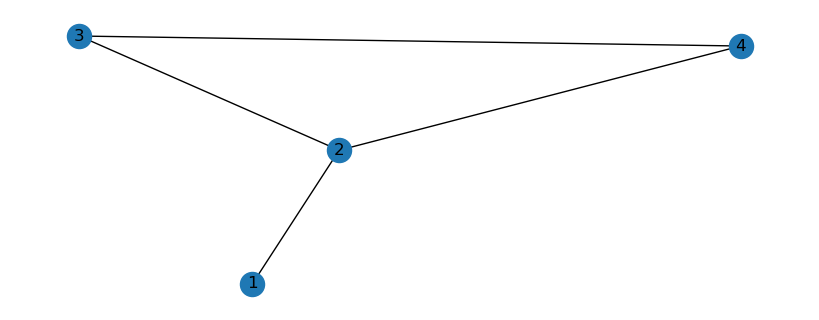

In [29]:
# let's apply it to example graph

import networkx as nx

# creating graph from external resources

nx_g = nx.from_edgelist([(2,1),(2,3),(4,2),(3,4)])


import matplotlib.pyplot as plt
#nx.draw(g, with_labels=True)
#plt.show()

fig = plt.figure(figsize=(8, 3))
nx.draw(nx_g, with_labels=True)

In [30]:
# defining node features

node_feats = torch.arange(8, dtype=torch.float32).view(1,4,2)

adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node featurs:\n",node_feats)
print("\nAdjecency matrix:\n", adj_matrix)

Node featurs:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjecency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


In [31]:
# Now let's apply a GCN layer to it: for simplycity we initialize linear weight matrix as identity mtrix so that input features are equal to the message

layer = GCNLayer(c_in=2,c_out=2)

layer.projection.weight.data = torch.Tensor([[1.,0.],[0.,1.]])
layer.projection.bias.data = torch.Tensor([0.,0.])

with torch.no_grad():
    out_feats = layer(node_feats,adj_matrix)

print("Adjecency matrix", adj_matrix)
print("Input feature",node_feats)
print("Output features",out_feats)

Adjecency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input feature tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


## GAT

In [63]:
# Graph Attention Network 

In [32]:
class GATLayer(nn.Module):

    def __init__(self,c_in,c_out,num_heads=1,concat_heads=True,alpha=0.2):

        """Inputs:

                c_in = dimentionality of input features
                c_out = dimentionality of output features

                num_heads = number of heads in attention mechanism
                conacat = if True outputs of all heads will be concatinated instead of averaging
                alpha= negative slope of leaky relu      
        """
        super().__init__()

        self.num_heads = num_heads
        self.concat_heads = concat_heads

        if self.concat_heads:
            assert c_out % num_heads == 0 ; "Number of output features must be the multiple of the count of heads"
            c_out = c_out // num_heads

        # sub module and parameters needed in the layer

        self.projection = nn.Linear(c_in,c_out*num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out)) # one per head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self,node_feats,adj_matrix,print_attn_probs=False):

        batch_size,num_nodes = node_feats.size(0),node_feats.size(1)

        # apply linear layer
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size,num_nodes,self.num_heads,-1)

        # we need to calculate the attention logits for every edge in the adjecency matrix
        # doing this on all possible nodes will be very expensive
        
        edges = adj_matrix.nonzero(as_tuple=False) # return indices where adjecency matrix is not zero

        node_feats_flat = node_feats.view(batch_size*num_nodes, self.num_heads,-1)

        edge_indices_row = edges[:,0] * num_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * num_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)
        ], dim=-1) # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0

        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)

        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats

        


In [33]:
layer = GATLayer(2,2, num_heads=2)
layer.projection.weight.data = torch.Tensor([[1.,0.],[0.,1.]])
layer.projection.bias.data = torch.Tensor([0.,0.])

layer.a.data=  torch.Tensor([[-0.2,0.3],[0.1,-0.1]])


with torch.no_grad():
    out_feats = layer(node_feats,adj_matrix,print_attn_probs=True)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Attention probs
 tensor([[[[0.3543, 0.6457, 0.0000, 0.0000],
          [0.1096, 0.1450, 0.2642, 0.4813],
          [0.0000, 0.1858, 0.2885, 0.5257],
          [0.0000, 0.2391, 0.2696, 0.4913]],

         [[0.5100, 0.4900, 0.0000, 0.0000],
          [0.2975, 0.2436, 0.2340, 0.2249],
          [0.0000, 0.3838, 0.3142, 0.3019],
          [0.0000, 0.4018, 0.3289, 0.2693]]]])
Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1.2913, 1.9800],
         [4.2344, 3.7725],
         [4.6798, 4.8362],
         [4.5043, 4.7351]]])


## Using Pytorch Geometric

In [2]:
import torch_geometric
import torch_geometric.nn as g_nn
import torch_geometric.data as g_data

#### Experiment on Graph Structures

##### We Fcous on Node Level task : Semi-Supervised Node classification

A popular example that we will use in this tutorial is the Cora dataset, a citation network among papers. The Cora consists of 2708 scientific publications with links between each other representing the citation of one paper by another. The task is to classify each publication into one of seven classes. Each publication is represented by a bag-of-words vector. This means that we have a vector of 1433 elements for each publication, where a 1 at feature  indicates that the -th word of a pre-defined dictionary is in the article.

In [34]:
# Load the dataset
from torch_geometric.transforms import NormalizeFeatures

dataset = torch_geometric.datasets.Planetoid(root="PyTorch_Practice_Models" ,name="Cora", transform=NormalizeFeatures())

In [36]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [37]:
# GCN using pytorch-geometric librarry


from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [38]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9466
Epoch: 002, Loss: 1.9405
Epoch: 003, Loss: 1.9344
Epoch: 004, Loss: 1.9276
Epoch: 005, Loss: 1.9177
Epoch: 006, Loss: 1.9085
Epoch: 007, Loss: 1.8978
Epoch: 008, Loss: 1.8913
Epoch: 009, Loss: 1.8760
Epoch: 010, Loss: 1.8672
Epoch: 011, Loss: 1.8529
Epoch: 012, Loss: 1.8471
Epoch: 013, Loss: 1.8397
Epoch: 014, Loss: 1.8175
Epoch: 015, Loss: 1.8009
Epoch: 016, Loss: 1.7831
Epoch: 017, Loss: 1.7812
Epoch: 018, Loss: 1.7553
Epoch: 019, Loss: 1.7327
Epoch: 020, Loss: 1.7210
Epoch: 021, Loss: 1.7216
Epoch: 022, Loss: 1.6956
Epoch: 023, Loss: 1.6848
Epoch: 024, Loss: 1.6620
Epoch: 025, Loss: 1.6428
Epoch: 026, Loss: 1.6428
Epoch: 027, Loss: 1.6133
Epoch: 028, Loss: 1.5913
Epoch: 029, Loss: 1.5533
Epoch: 030, Loss: 1.5325
Epoch: 031, Loss: 1.5367
Epoch: 032, Loss: 1.5215
Epoch: 033, Loss: 1.4778
Epoch: 034, Loss: 1.4963
Epoch: 035, Loss: 1.4301
Epoch: 036, Loss: 1.4143
Epoch: 037, Loss: 1.3961
Epoch: 038, Loss: 1.3679
Epoch: 039, Loss: 1.3656
Epoch: 040, Loss: 1.3615


In [39]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7910


In [40]:
# GAT

from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(12)
        self.conv1 = GATConv(dataset.num_features, hidden_channels) 
        self.conv2 = GATConv(hidden_channels, dataset.num_classes) 

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=1)
  (conv2): GATConv(8, 7, heads=1)
)
Epoch: 001, Loss: 1.9457, Val: 0.2000, Test: 0.2000
Epoch: 002, Loss: 1.9421, Val: 0.2080, Test: 0.1740
Epoch: 003, Loss: 1.9403, Val: 0.2240, Test: 0.2030
Epoch: 004, Loss: 1.9368, Val: 0.2920, Test: 0.2750
Epoch: 005, Loss: 1.9341, Val: 0.3940, Test: 0.3900
Epoch: 006, Loss: 1.9304, Val: 0.4680, Test: 0.4560
Epoch: 007, Loss: 1.9281, Val: 0.5620, Test: 0.5630
Epoch: 008, Loss: 1.9228, Val: 0.5920, Test: 0.5820
Epoch: 009, Loss: 1.9207, Val: 0.5560, Test: 0.5550
Epoch: 010, Loss: 1.9206, Val: 0.5600, Test: 0.5660
Epoch: 011, Loss: 1.9107, Val: 0.5680, Test: 0.5790
Epoch: 012, Loss: 1.9135, Val: 0.6040, Test: 0.6000
Epoch: 013, Loss: 1.9062, Val: 0.6600, Test: 0.6470
Epoch: 014, Loss: 1.9065, Val: 0.7060, Test: 0.7050
Epoch: 015, Loss: 1.8982, Val: 0.7340, Test: 0.7290
Epoch: 016, Loss: 1.8996, Val: 0.7480, Test: 0.7310
Epoch: 017, Loss: 1.8939, Val: 0.7440, Test: 0.7270
Epoch: 018, Loss: 1.8918, Val: 0.7340,

In [41]:
test_acc = test(mask=data.train_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9643
